In [10]:
#Import libraries
import pandas as pd
import numpy as nppi
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FixedLocator
from tabulate import tabulate  
import pickle

KeyboardInterrupt: 

In [ ]:
# Loading the data and renaming it
data = pd.read_csv('Concrete_Data.csv',encoding='latin1')
req_names = ["Cement", "BlastFurnaceSlag", "FlyAsh", "Water", "Superplasticizer",
             "CoarseAggregate", "FineAggregate", "Age", "CC_Strength"]
curr_names = list(data.columns)
mapper = {curr: req for curr, req in zip(curr_names, req_names)}
data = data.rename(columns=mapper)

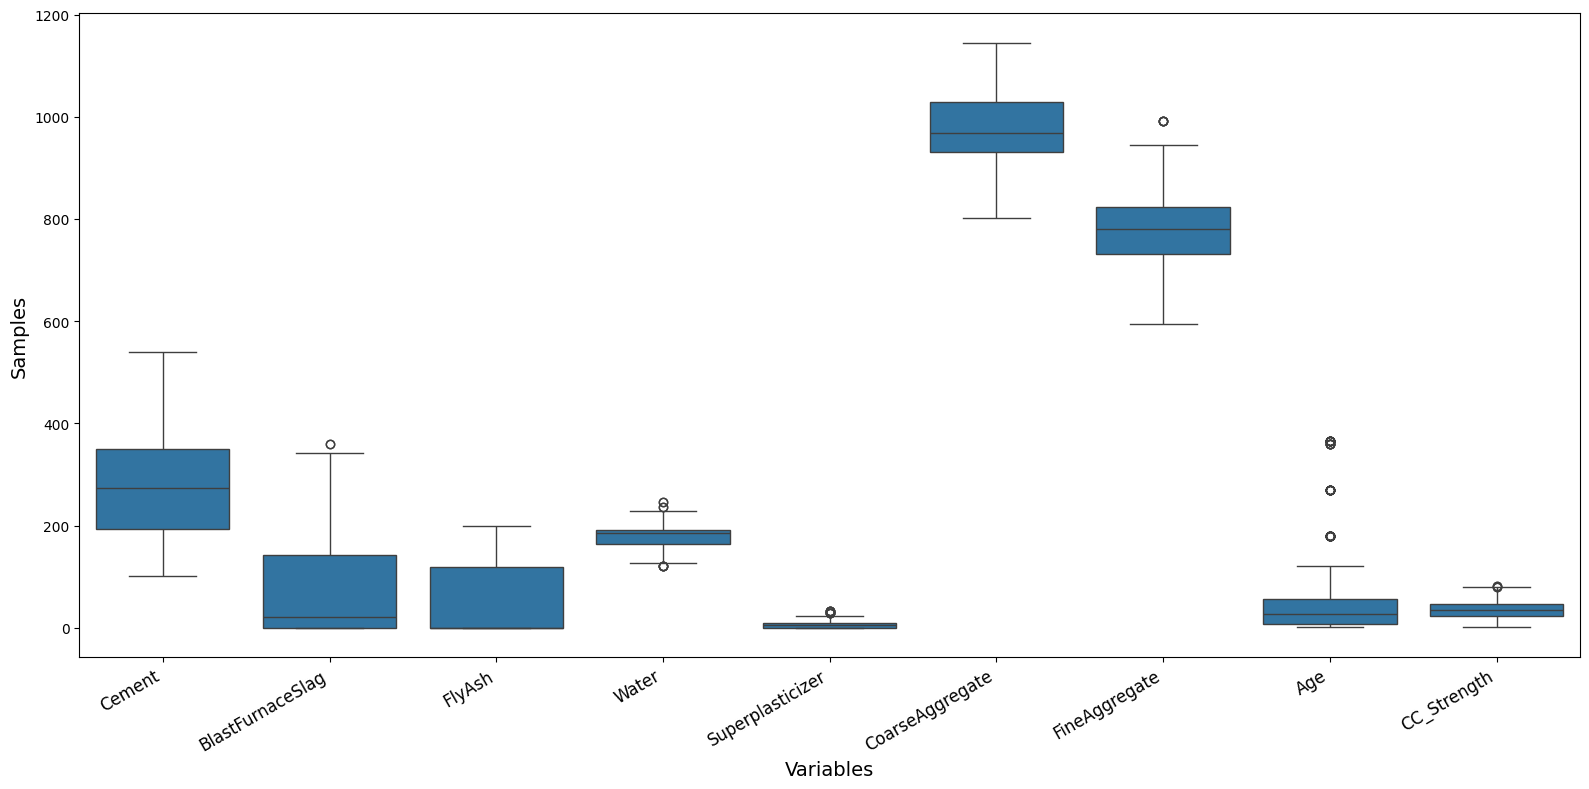

In [ ]:
# Outlier detection and box plot
plt.figure(figsize=(16, 8)) 
melted_data = data.melt(var_name='Variable', value_name='Value')
sns.boxplot(x='Variable', y='Value', data=melted_data)
plt.xticks(rotation=30, fontsize=12, ha='right') 
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Samples', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Outlier detection and elimination
outliers_count = {}
mask = pd.Series(False, index=data.index)

for column in data.columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column_outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    outliers_count[column] = column_outliers.sum()
    mask = mask | column_outliers
cleaned_data = data[~mask]

# Display the number of outliers for each variable
print("Number of outliers detected in each variable:")
for variable, count in outliers_count.items():
    print(f"{variable}: {count}")
print(f"\nOriginal data shape: {data.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")

Number of outliers detected in each variable:
Cement: 0
BlastFurnaceSlag: 2
FlyAsh: 0
Water: 9
Superplasticizer: 10
CoarseAggregate: 0
FineAggregate: 5
Age: 59
CC_Strength: 4

Original data shape: (1030, 9)
Cleaned data shape: (941, 9)


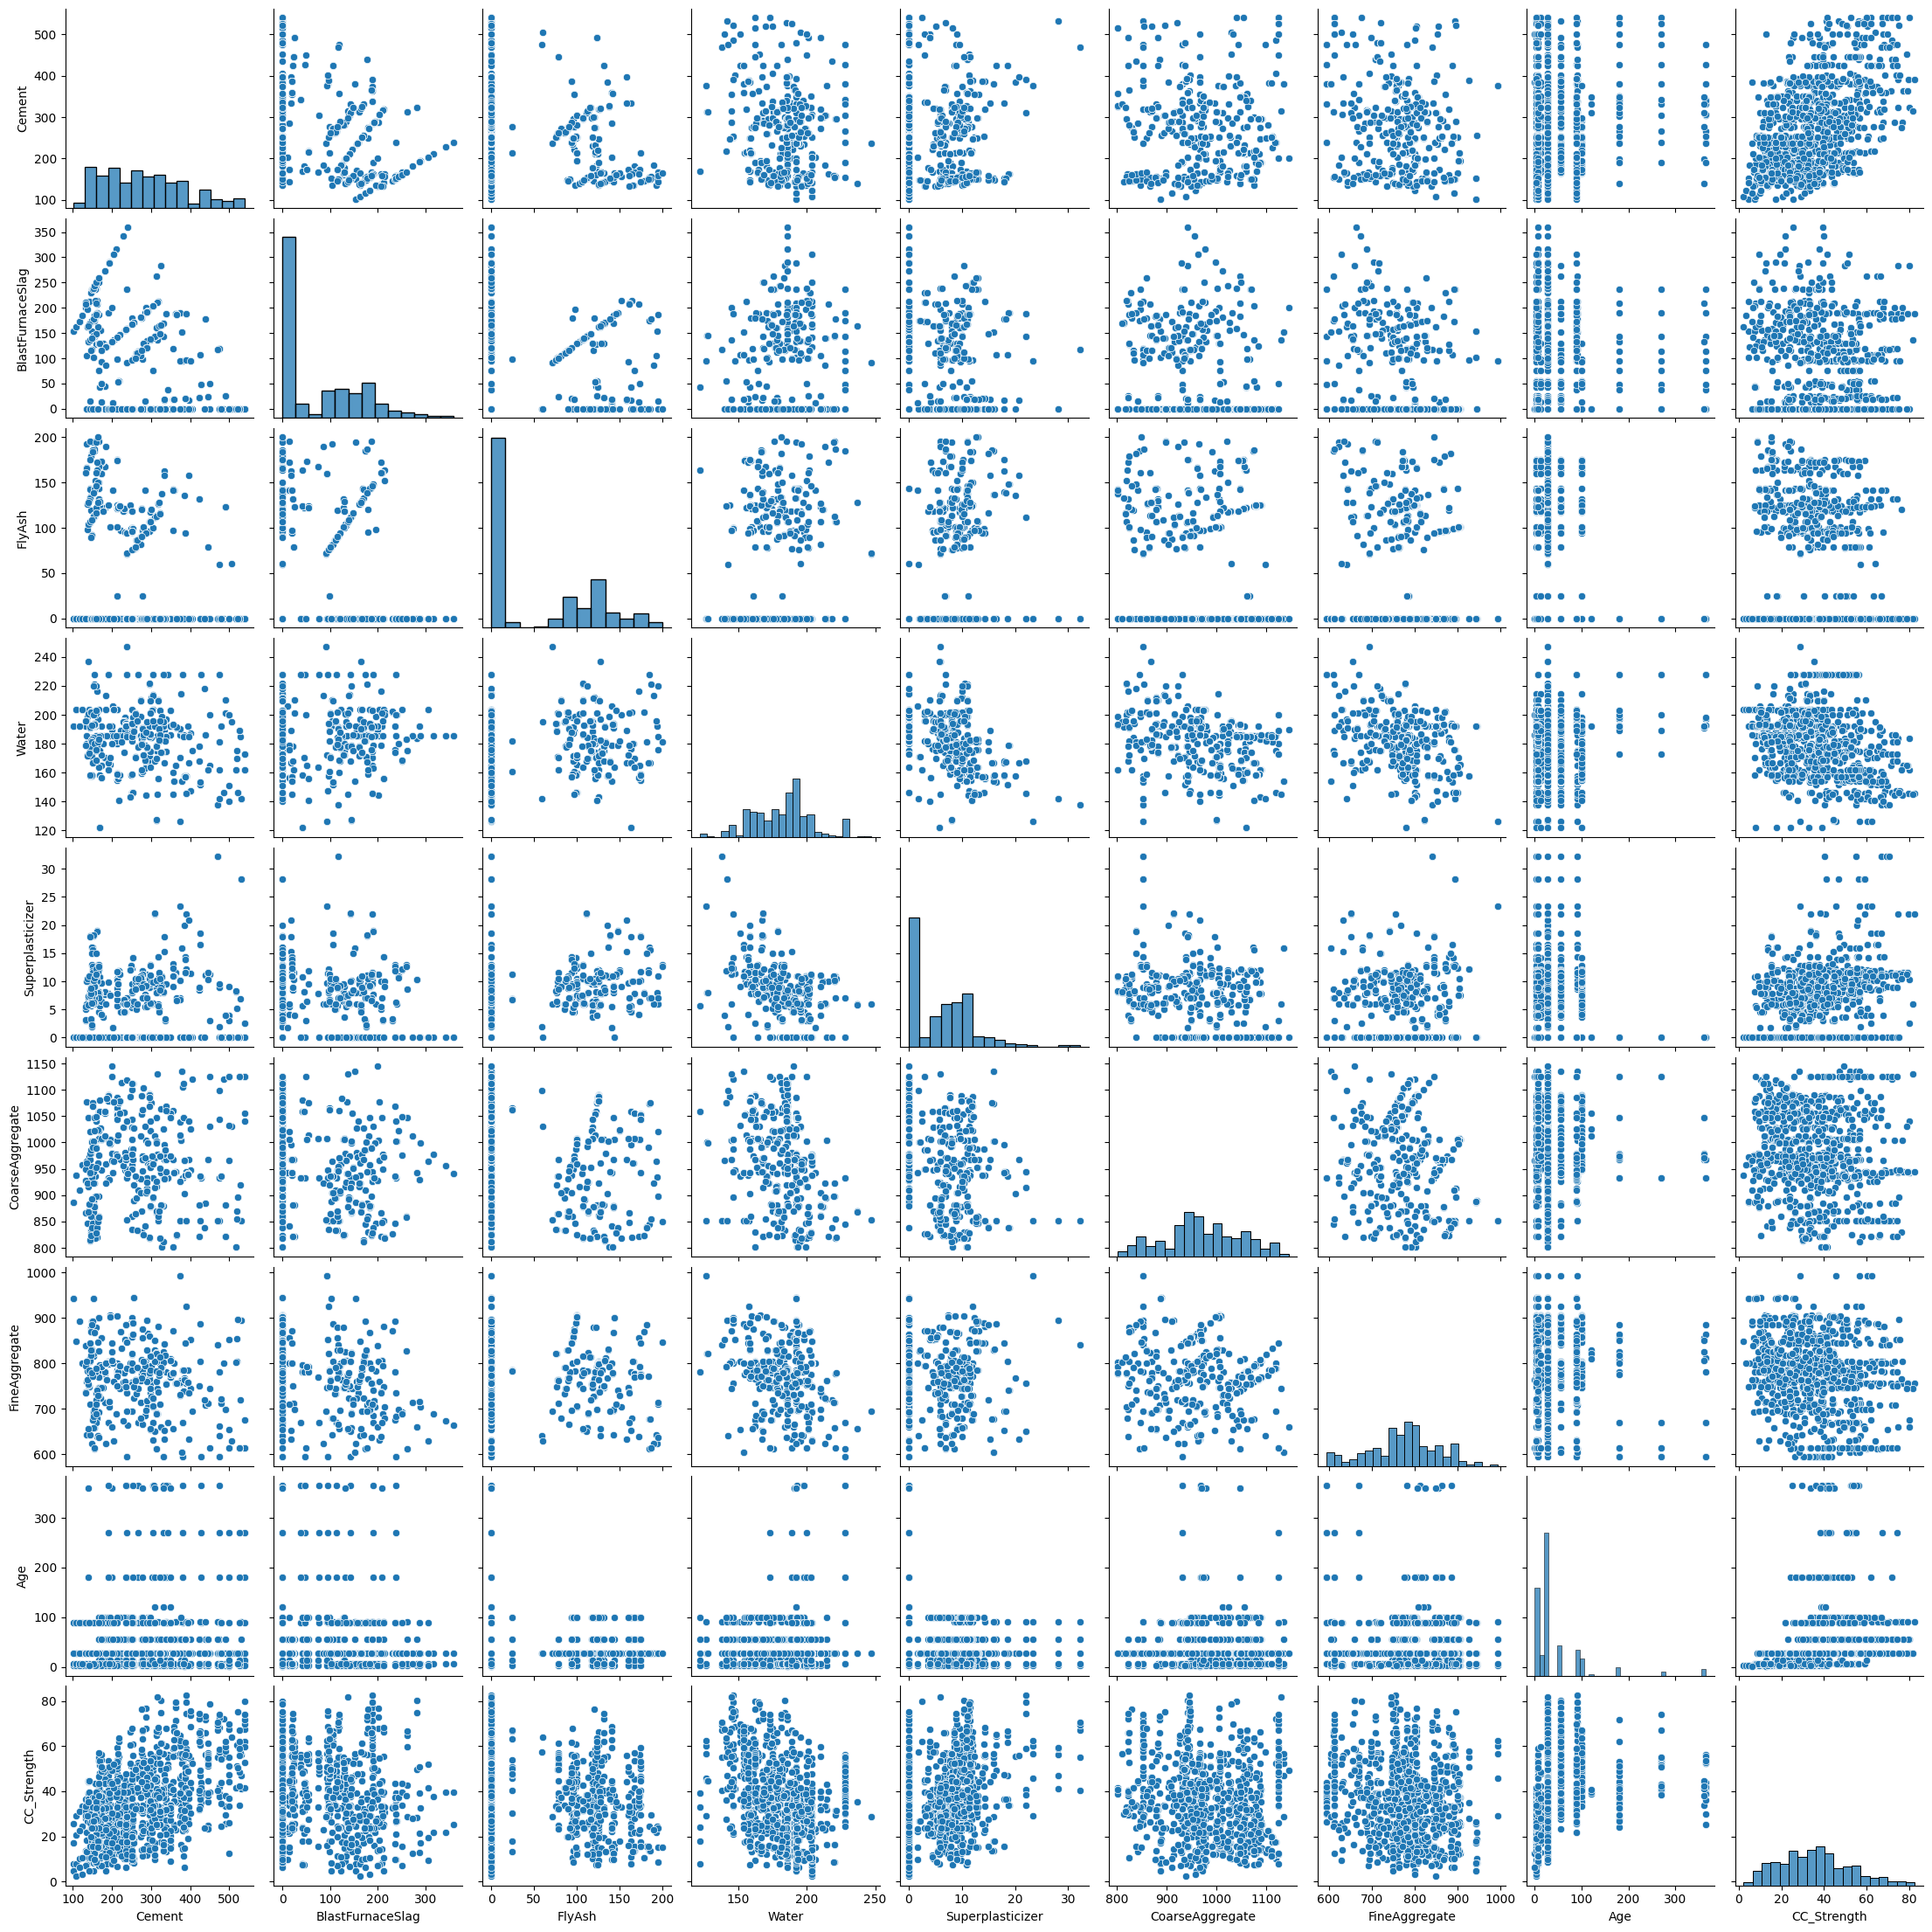

In [ ]:
# Create the pairplot for variables 
sns.pairplot(data)
plt.savefig("relationship-of-input-variables.png")
plt.show()

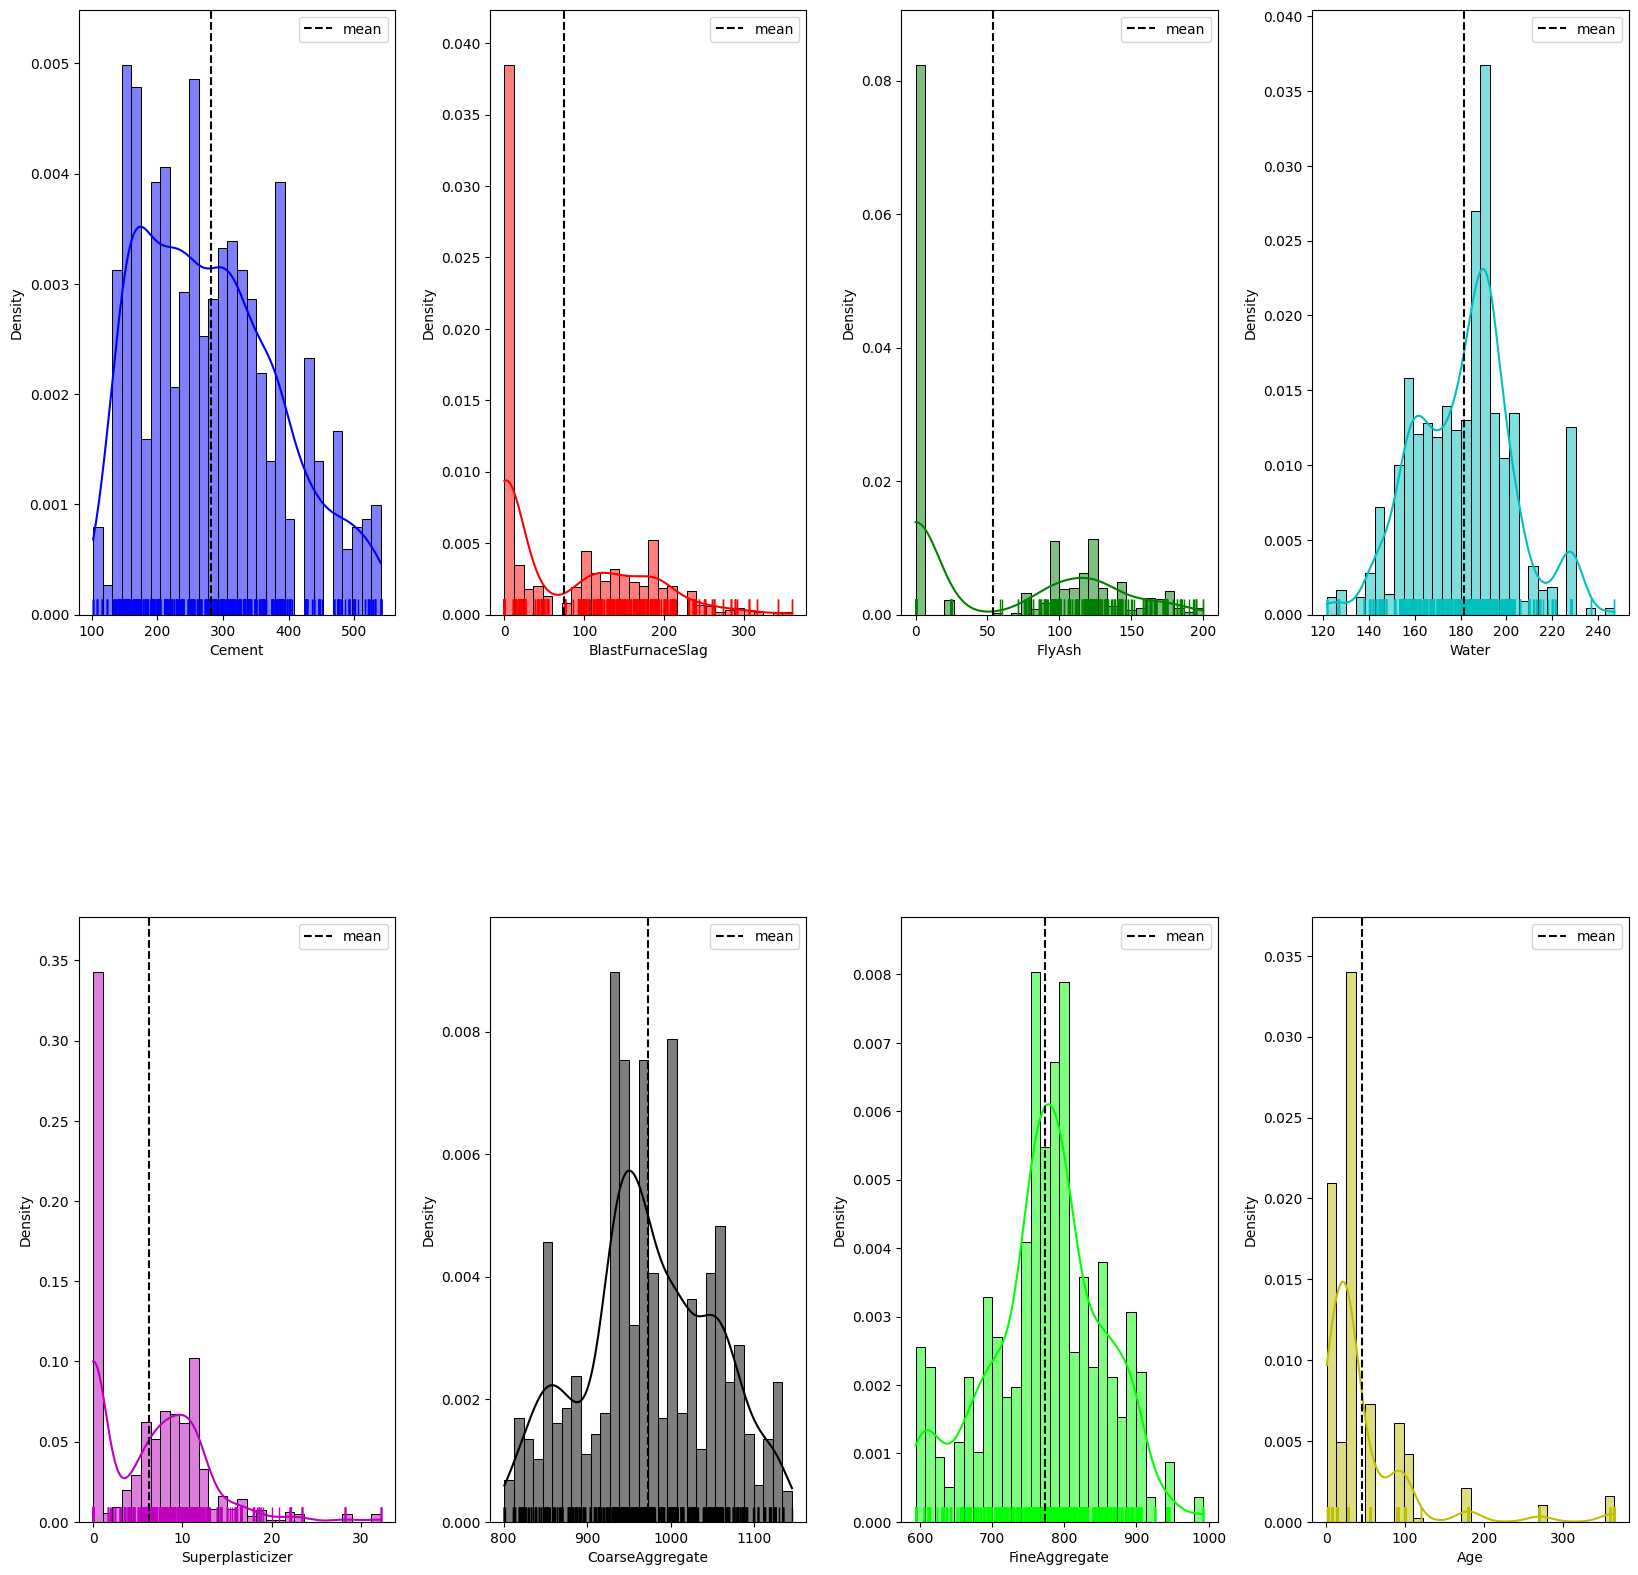

In [ ]:

# Distribution plot
cols = [col for col in data.columns if col != 'CC_Strength']
length = len(cols)
cs = ["b", "r", "g", "c", "m", "k", "lime", "y"]
fig = plt.figure(figsize=(20, 18))
num_cols = 4 
num_rows = (length // num_cols) + (length % num_cols > 0)

for i, j, k in it.zip_longest(cols, range(length), cs):
    plt.subplot(num_rows, num_cols, j + 1)  
    ax = sns.histplot(data[i], kde=True, bins=30, color=k, stat="density")  
    sns.rugplot(x=data[i], color=k, ax=ax)
    ax.set_facecolor("w")
    plt.axvline(data[i].mean(), linestyle="dashed", label="mean", color="k")
    plt.legend(loc="best")
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95)
plt.savefig("distribution_plot.png")
plt.show()


In [ ]:
# Calculate and print statistics and percentiles
stats = data.describe().T[['mean', 'std', 'min', 'max', '25%', '50%', '75%']]
print("Basic and Percentile statistics (mean, std, min, max, 25%, 50%, 75%):")
print(stats.to_string())

Basic and Percentile statistics (mean, std, min, max, 25%, 50%, 75%):
                        mean         std     min     max      25%      50%       75%
Cement            281.167864  104.506364  102.00   540.0  192.375  272.900   350.000
BlastFurnaceSlag   73.895825   86.279342    0.00   359.4    0.000   22.000   142.950
FlyAsh             54.188350   63.997004    0.00   200.1    0.000    0.000   118.300
Water             181.567282   21.354219  121.80   247.0  164.900  185.000   192.000
Superplasticizer    6.204660    5.973841    0.00    32.2    0.000    6.400    10.200
CoarseAggregate   972.918932   77.753954  801.00  1145.0  932.000  968.000  1029.400
FineAggregate     773.580485   80.175980  594.00   992.6  730.950  779.500   824.000
Age                45.662136   63.169912    1.00   365.0    7.000   28.000    56.000
CC_Strength        35.817961   16.705742    2.33    82.6   23.710   34.445    46.135


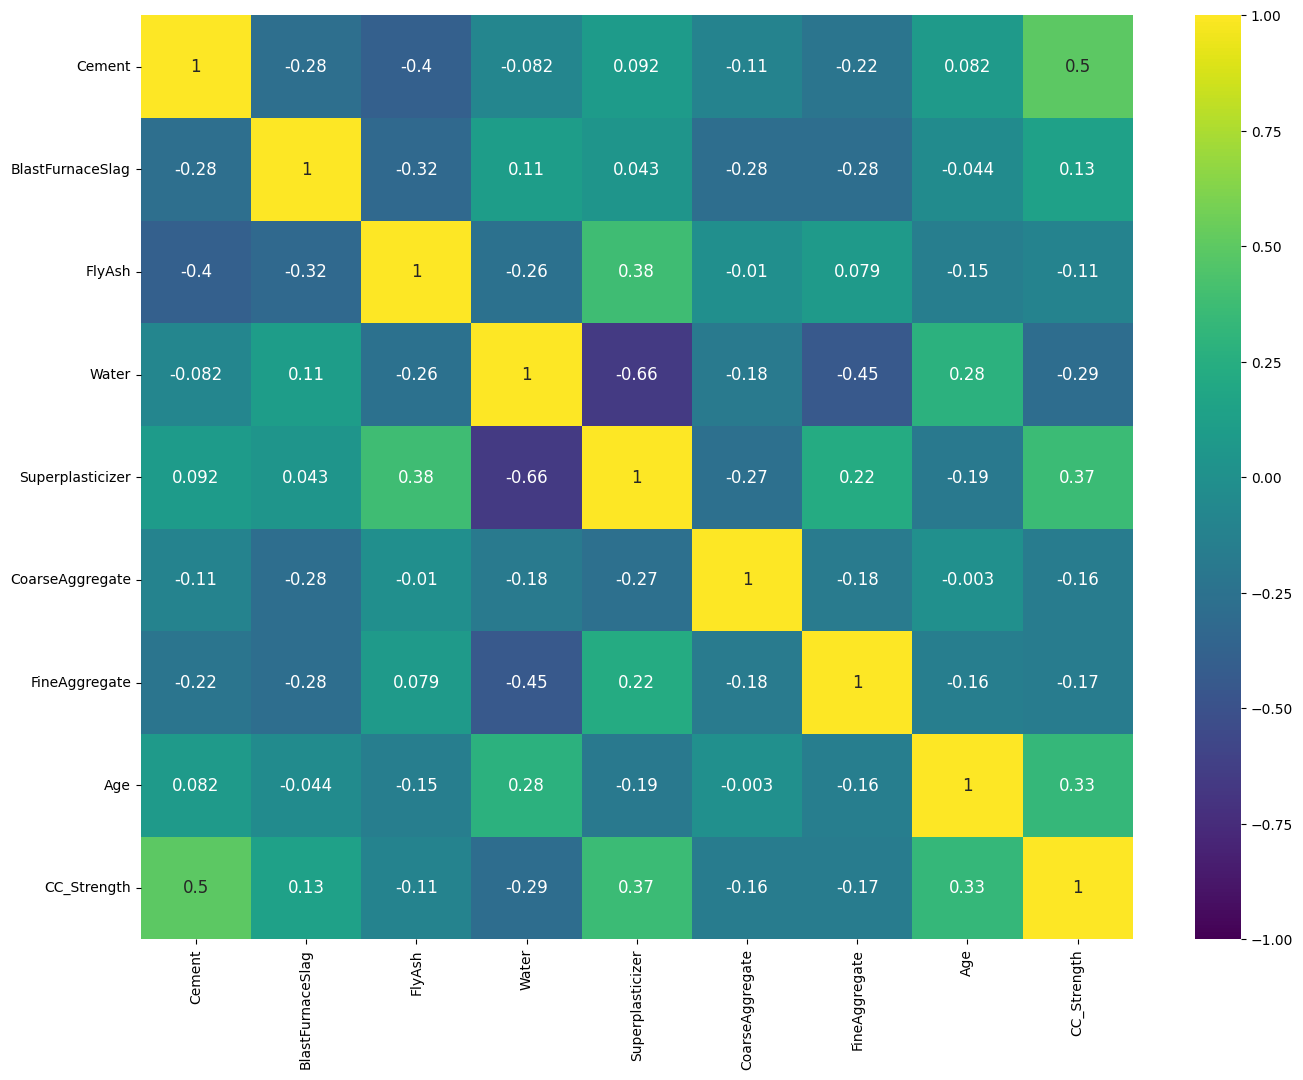

In [ ]:
# Calculate the correlation matrix
corr_matrix = data.corr() 
plt.figure(figsize=(16, 12)) 
sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, annot_kws={"size": 12})
plt.show()

In [ ]:
# Targeting variables and scaling
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

In [ ]:
# Define models and parameter grids
models = {
    'XGBoost': XGBRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}

param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
}

In [ ]:
# Train the models (initial evaluation)
cv_results = {
    model_name: {
        'R2': [], 'MSE': [], 'MAE': [], 'RMSE': [], 'MAPE': [],
        'best_params': {}, 'predictions': []
    }
    for model_name in models
}

xgboost_tuned = cv_results['XGBoost']['best_params']
xgboost_tuned_model = XGBRegressor(**xgboost_tuned, random_state=42)
xgboost_tuned_model.fit(X_train_scaled, y_train)
xgboost_pred = xgboost_tuned_model.predict(X_test_scaled)

random_forest_tuned = cv_results['Random Forest']['best_params']
random_forest_tuned_model = RandomForestRegressor(**random_forest_tuned, random_state=42)
random_forest_tuned_model.fit(X_train_scaled, y_train)
random_forest_pred = random_forest_tuned_model.predict(X_test_scaled)

knn_tuned = cv_results['KNN']['best_params']
knn_tuned_model = KNeighborsRegressor(**knn_tuned)
knn_tuned_model.fit(X_train_scaled, y_train)
knn_pred = knn_tuned_model.predict(X_test_scaled)


In [ ]:
# MAPE Function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Perform GridSearchCV with 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name],
                               scoring='neg_mean_squared_error', cv=kf, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    cv_results[model_name]['best_params'] = grid_search.best_params_

    for train_index, test_index in kf.split(X_scaled):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]

        best_model.fit(X_train_cv, y_train_cv)
        y_pred_cv = best_model.predict(X_test_cv)

        cv_results[model_name]['R2'].append(r2_score(y_test_cv, y_pred_cv))
        cv_results[model_name]['MSE'].append(mean_squared_error(y_test_cv, y_pred_cv))
        cv_results[model_name]['MAE'].append(mean_absolute_error(y_test_cv, y_pred_cv))
        cv_results[model_name]['RMSE'].append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))
        cv_results[model_name]['MAPE'].append(mean_absolute_percentage_error(y_test_cv, y_pred_cv))
        cv_results[model_name]['predictions'].append(y_pred_cv)

# Print cross-validation results for each fold
for model_name, metrics in cv_results.items():
    print(f"\n{model_name} - Cross-Validation Results:")
    fold_results = [
        [f"Fold {i + 1}", metrics['R2'][i], metrics['MSE'][i], metrics['MAE'][i], metrics['RMSE'][i], metrics['MAPE'][i]]
        for i in range(10)
    ]
    print(tabulate(fold_results, headers=["Fold", "R-squared", "MSE", "MAE", "RMSE", "MAPE (%)"], tablefmt="fancy_grid"))
    


XGBoost - Cross-Validation Results:
╒═════════╤═════════════╤══════════╤═════════╤═════════╤════════════╕
│ Fold    │   R-squared │      MSE │     MAE │    RMSE │   MAPE (%) │
╞═════════╪═════════════╪══════════╪═════════╪═════════╪════════════╡
│ Fold 1  │    0.942814 │ 15.2074  │ 2.60947 │ 3.89967 │    8.97607 │
├─────────┼─────────────┼──────────┼─────────┼─────────┼────────────┤
│ Fold 2  │    0.945562 │ 13.4002  │ 2.62192 │ 3.66063 │    8.21948 │
├─────────┼─────────────┼──────────┼─────────┼─────────┼────────────┤
│ Fold 3  │    0.947841 │ 15.3374  │ 2.59095 │ 3.9163  │    9.89742 │
├─────────┼─────────────┼──────────┼─────────┼─────────┼────────────┤
│ Fold 4  │    0.92679  │ 27.0934  │ 3.43435 │ 5.20513 │   11.2149  │
├─────────┼─────────────┼──────────┼─────────┼─────────┼────────────┤
│ Fold 5  │    0.887102 │ 29.4408  │ 3.12274 │ 5.42594 │   10.5166  │
├─────────┼─────────────┼──────────┼─────────┼─────────┼────────────┤
│ Fold 6  │    0.967599 │  9.86109 │ 2.33983 │ 3.1402

In [ ]:
# Calculate average metrics across 10 folds
avg_metrics = {
    model_name: {
        metric: np.mean(values)
        for metric, values in metrics.items()
        if metric not in ['best_params', 'predictions']
    }
    for model_name, metrics in cv_results.items()
}

# Print best parameters and overall results as a table
overall_results = []
for model_name, results in cv_results.items():
    overall_results.append([
        model_name,
        results['best_params'],
        avg_metrics[model_name]['R2'],
        avg_metrics[model_name]['MSE'],
        avg_metrics[model_name]['MAE'],
        avg_metrics[model_name]['RMSE'],
        avg_metrics[model_name]['MAPE']
    ])

print("Summary of Model Performance:")
print(tabulate(overall_results, headers=["Model", "Best Parameters", "R-squared", "MSE", "MAE", "RMSE", "MAPE (%)"], tablefmt="fancy_grid"))


Summary of Model Performance:
╒═══════════════╤═══════════════════════════════════════════════════════════════════════════════════════╤═════════════╤═════════╤═════════╤═════════╤════════════╕
│ Model         │ Best Parameters                                                                       │   R-squared │     MSE │     MAE │    RMSE │   MAPE (%) │
╞═══════════════╪═══════════════════════════════════════════════════════════════════════════════════════╪═════════════╪═════════╪═════════╪═════════╪════════════╡
│ XGBoost       │ {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}                           │    0.939601 │ 16.6741 │ 2.72826 │ 4.02079 │    9.52771 │
├───────────────┼───────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼────────────┤
│ Random Forest │ {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} │    0.914713 │ 23.4427 │ 3.31418 │ 4.80569 │   11.

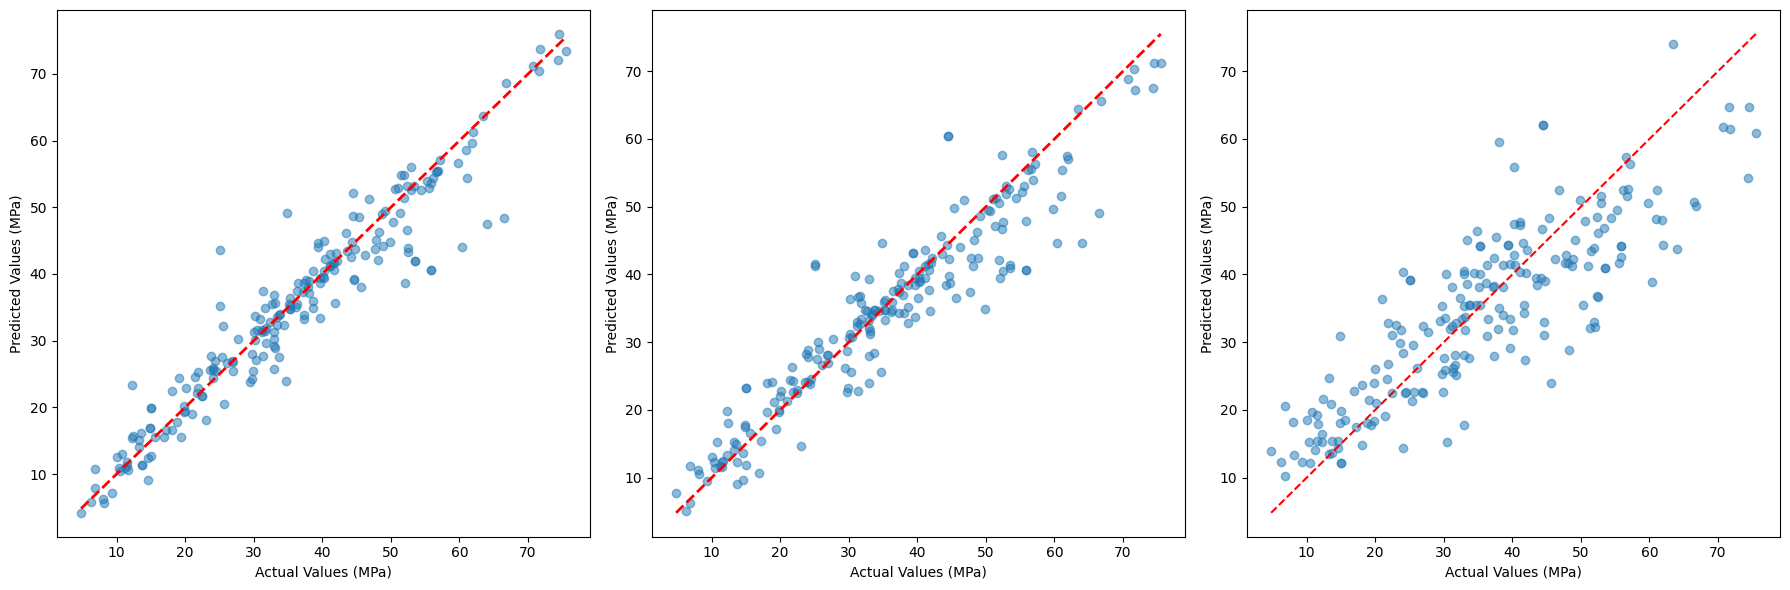

In [ ]:
# Scatter plot for predicted vs. actual values (for all models)
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(y_test, xgboost_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values (MPa)")
plt.ylabel("Predicted Values (MPa)")

plt.subplot(1, 3, 2)
plt.scatter(y_test, random_forest_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values (MPa)")
plt.ylabel("Predicted Values (MPa)")

plt.subplot(1, 3, 3)
plt.scatter(y_test, knn_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values (MPa)")
plt.ylabel("Predicted Values (MPa)")
plt.tight_layout()
plt.show()

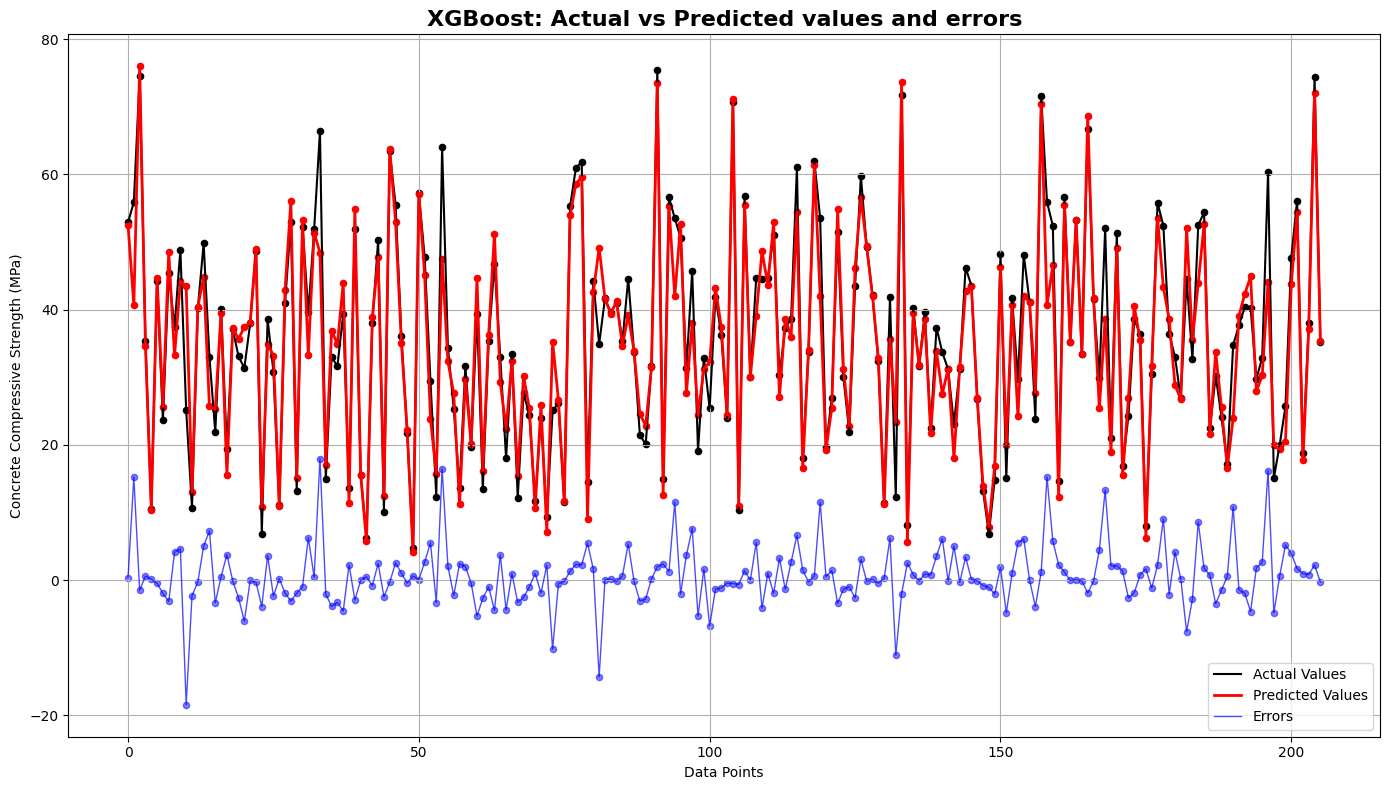

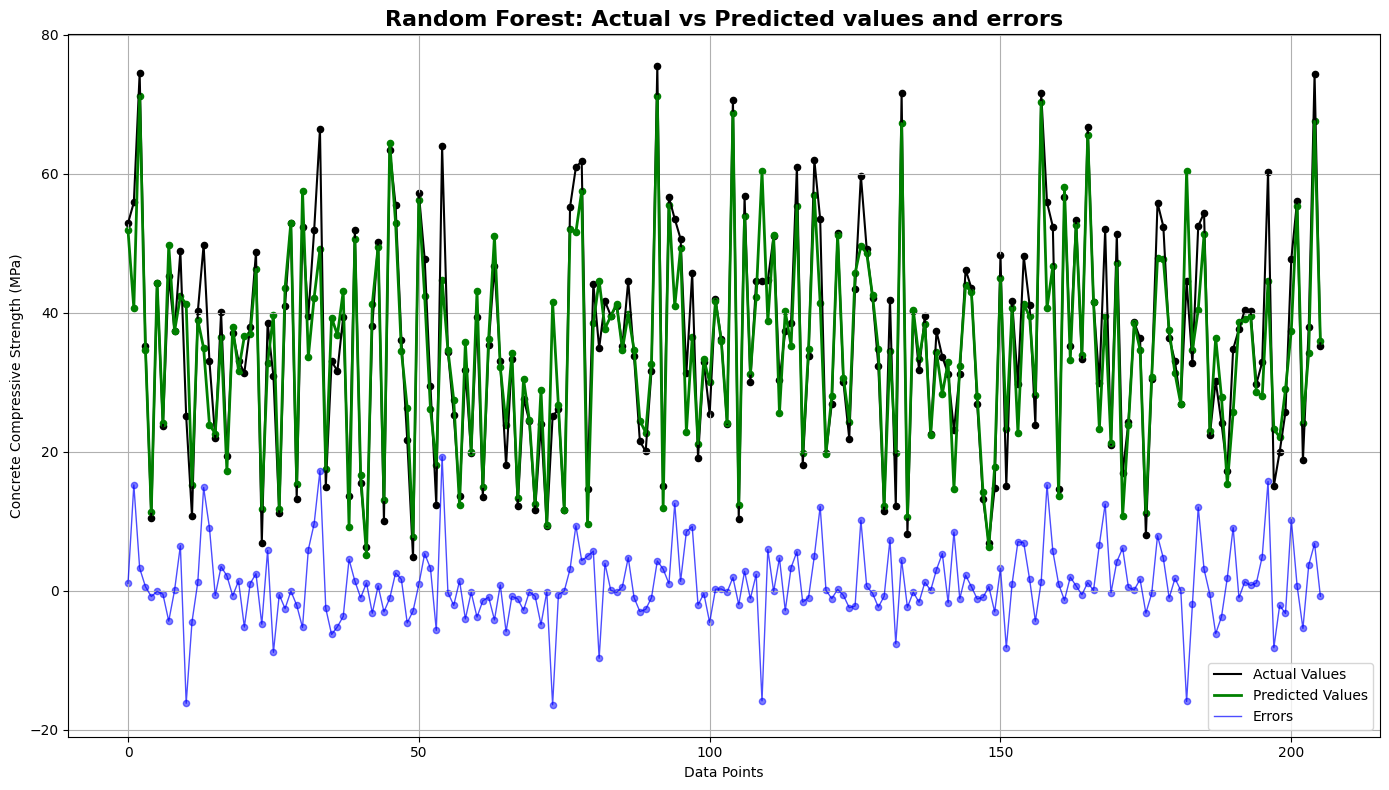

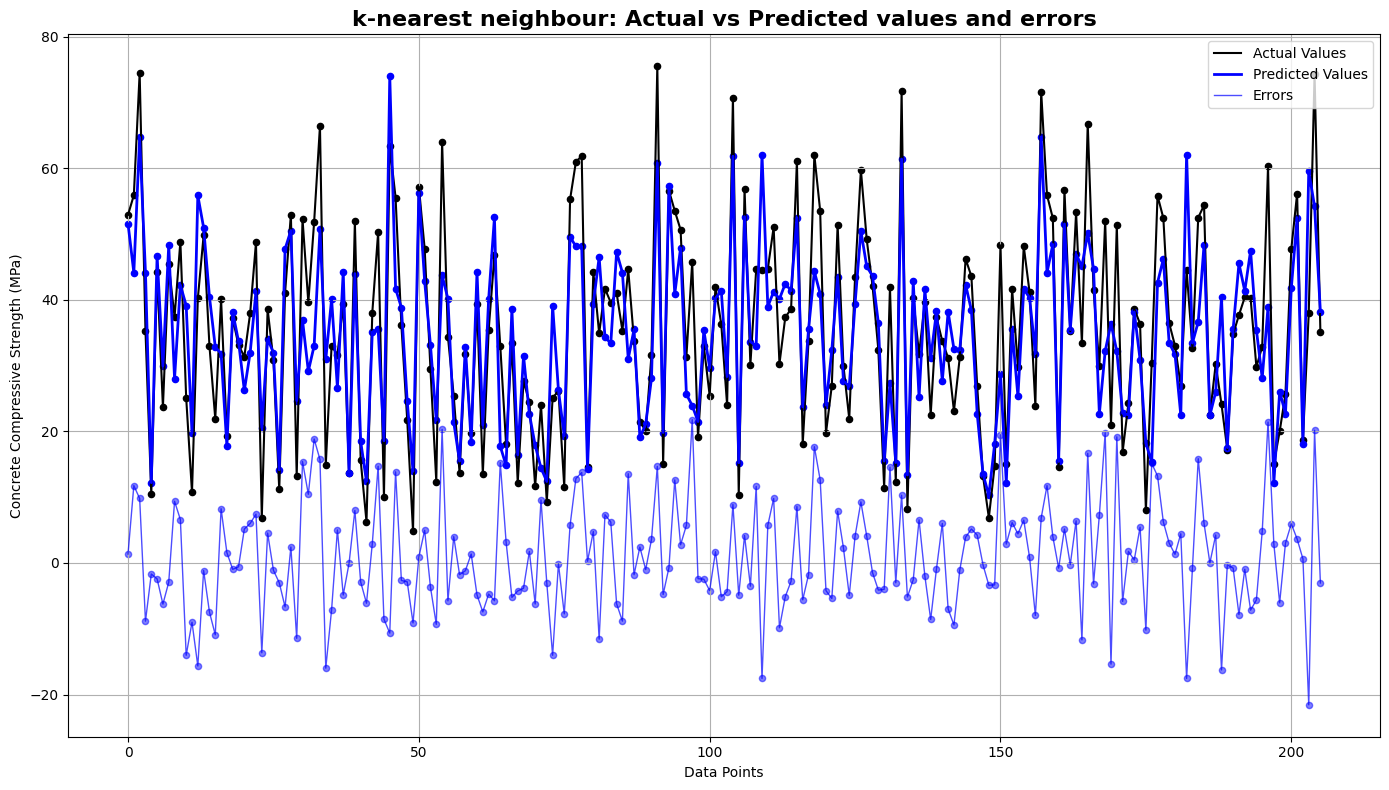

In [ ]:
# Plot for XGBoost: Actual vs Predicted Values and Errors
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, 'k-', label='Actual Values') 
plt.scatter(range(len(y_test)), y_test, color='black', s=20) 
plt.plot(range(len(y_test)), xgboost_pred, 'r-', linewidth=2, label='Predicted Values')  
plt.scatter(range(len(y_test)), xgboost_pred, color='red', s=20)  
xgboost_errors = y_test - xgboost_pred
plt.plot(range(len(y_test)), xgboost_errors, 'b-', linewidth=1, alpha=0.7, label='Errors')  # Blue line for errors
plt.scatter(range(len(y_test)), xgboost_errors, color='blue', alpha=0.5, s=20)  # Blue dots for errors
plt.xlabel('Data Points')
plt.ylabel('Concrete Compressive Strength (MPa)')
plt.legend()
plt.title('XGBoost: Actual vs Predicted values and errors', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Random Forest: Actual vs Predicted Values and Errors
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, 'k-', label='Actual Values')
plt.scatter(range(len(y_test)), y_test, color='black', s=20)
plt.plot(range(len(y_test)), random_forest_pred, 'g-', linewidth=2, label='Predicted Values')
plt.scatter(range(len(y_test)), random_forest_pred, color='green', s=20)
random_forest_errors = y_test - random_forest_pred
plt.plot(range(len(y_test)), random_forest_errors, 'b-', linewidth=1, alpha=0.7, label='Errors')
plt.scatter(range(len(y_test)), random_forest_errors, color='blue', alpha=0.5, s=20)
plt.xlabel('Data Points')
plt.ylabel('Concrete Compressive Strength (MPa)')
plt.legend()
plt.title('Random Forest: Actual vs Predicted values and errors', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for KNN: Actual vs Predicted Values and Errors
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, 'k-', label='Actual Values')
plt.scatter(range(len(y_test)), y_test, color='black', s=20)
plt.plot(range(len(y_test)), knn_pred, 'b-', linewidth=2, label='Predicted Values')
plt.scatter(range(len(y_test)), knn_pred, color='blue', s=20)
knn_errors = y_test - knn_pred
plt.plot(range(len(y_test)), knn_errors, 'b-', linewidth=1, alpha=0.7, label='Errors')
plt.scatter(range(len(y_test)), knn_errors, color='blue', alpha=0.5, s=20)
plt.xlabel('Data Points')
plt.ylabel('Concrete Compressive Strength (MPa)')
plt.legend()
plt.title('k-nearest neighbour: Actual vs Predicted values and errors', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()
